In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

***
### Funções

In [2]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [3]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

***
## Coleta de dados

In [4]:
FILE = "/kaggle/input/bigdata/batdtfim_full.csv"

In [5]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [6]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
    new_clients = new_clients.sample(frac = 0.01)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [7]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.idade': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\
#              .drop_duplicates().reset_index(drop=True)

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,5524999642424,724112692904913,35385532,2021-09-03,NaN,13,1,0,APPLE,IPHONE 11 (A2221),...,RIO DE JANEIRO,VIVO CONTROLE 8GB II,60.99,0.0,1.0,0.0,2020.0,42.0,0.0,0.0
1,5519997091978,724101815151129,35186592,2021-05-06,NaN,17,1,0,LG Electronics Inc.,LM-K410BMW,...,SAO PAULO,VIVOCONTROLEDIGITAL-9GB ILIM_,95.99,0.0,1.0,0.0,2020.0,70.0,0.0,0.0
2,5511999771029,724102293433387,35304253,2021-08-30,NaN,13,1,0,Samsung Korea,GALAXY S20 FE LTE,...,SAO PAULO,TITULAR VIVO FAMILIA 60GB,185.62,0.0,1.0,0.0,2021.0,66.0,0.0,0.0
3,5531993568660,724233603510167,35291711,2020-10-17,2022-04-02,17,1,1,APPLE,IPHONE 11 (A2221),...,MINAS GERAIS,VIVO CONTROLE 9GB I PLN,55.99,0.0,1.0,0.0,2020.0,67.0,17.0,17.0
4,5537998419990,724233765709203,35414310,2021-07-12,NaN,15,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO G PLAY (7TH GEN),...,MINAS GERAIS,VIVO CONTROLE 4GB IV,32.49,0.0,1.0,0.0,2019.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79088,5591991635687,724119897516128,35917308,2021-08-01,NaN,14,1,0,LG,K10 2017 (M250DS),...,PARA,VIVO CONTROLE 3GB V,27.99,0.0,1.0,0.0,2017.0,62.0,0.0,0.0
79089,5591993164565,724119808711587,35558009,2021-09-17,NaN,13,1,0,MOTOROLA,MOTO G7 PLAY (XT1952-2),...,PARA,VIVO CONTROLE DIGITAL_7GB_,50.31,0.0,1.0,0.0,2018.0,45.0,0.0,0.0
79090,5593991611109,724119001680551,86983905,2021-08-26,NaN,13,1,0,Xiaomi Communications Co Ltd,REDMI NOTE 10,...,PARA,VIVO CONTROLE 5GB II,44.85,0.0,1.0,0.0,2020.0,38.0,0.0,0.0
79091,5592981406615,724119207225814,35577411,2021-05-12,NaN,17,1,0,SAMSUNG,"GALAXY A51 (SM-A515F,DSN)",...,AMAZONAS,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,0.00,0.0,1.0,0.0,2020.0,30.0,0.0,0.0


### Limpeza dos dados

In [8]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     66424
citydesc                   79093
statedesc                      5
subscribermainofferdesc      134
assignedchargeamount         124
fl_3g                         15
fl_4g                         15
fl_5g                         15
dt_ano_stts                   15
dtype: int64

columns_with_nan.shape (9,)



In [9]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade'])\
                    .reset_index(drop=True)
# dados_droped

In [10]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      66276
citydesc    78929
dtype: int64

columns_with_nan.shape (2,)



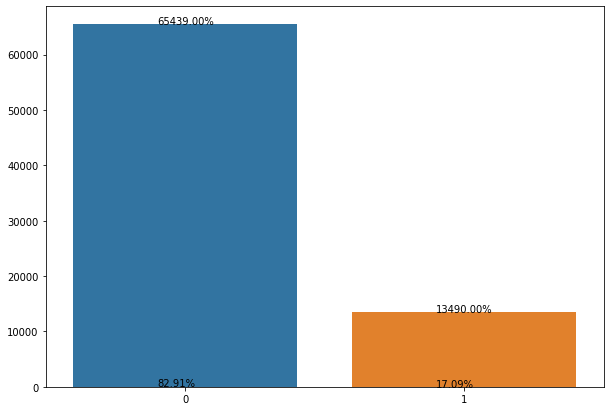

In [11]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

### Equilibrando classes

In [12]:
dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.35, random_state=3)
dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [13]:
dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
2384,5599999514051,724119896599686,35179339,2021-08-30,NaN,13,1,0,APPLE,IPHONE 12 (A2172),...,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,0.0,1.0,2020.0,60.0,13.0,5.67
36043,5599999041625,724119813970292,35468011,2020-10-30,2022-02-19,15,1,1,Samsung Korea,GALAXY S20,...,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,1.0,0.0,2019.0,46.0,0.0,15.00
12040,5599996471818,724119896006113,35299510,2021-07-20,NaN,15,1,0,SAMSUNG,"GALAXY J6 (SM-J600GT,DS)",...,MARANHAO,VIVO CONTROLE 9GB I,60.74,0.0,1.0,0.0,2018.0,46.0,0.0,0.00
24078,5599992301834,724119892795038,35571411,2020-09-19,2022-02-17,16,1,1,Samsung Korea,GALAXY J2 CORE,...,MARANHAO,VIVO CONTROLE-9GB ILIM_,66.99,0.0,1.0,0.0,2020.0,76.0,16.0,16.00
26523,5599992274142,724119109936296,86890904,2021-04-22,2022-04-25,12,1,1,XIAOMI,REDMI NOTE 8 PRO (M1906G7G),...,MARANHAO,VIVO CTRL DIGITAL-14GB ILIM_,86.99,0.0,1.0,0.0,2019.0,44.0,12.0,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25629,5511910021165,724102901916694,35183711,2020-10-15,2022-03-17,17,1,1,Samsung Korea,GALAXY A10S,...,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2019.0,39.0,0.0,14.00
16331,5511910017834,724101106626336,35547360,2021-08-15,NaN,14,1,0,Samsung Korea,GALAXY A02S,...,SAO PAULO,VIVO CONTROLE 5GB II,42.19,0.0,1.0,0.0,2020.0,38.0,0.0,0.00
31225,5511910012510,724102111092552,86987605,2020-12-24,2022-03-05,14,1,1,XIAOMI,REDMI 9 (M2004J19G),...,SAO PAULO,Linha Adicional Vivo Pós Família 300GB,69.99,0.0,1.0,0.0,2020.0,44.0,4.0,13.00
10724,5511910010690,724102091025544,35179738,2021-05-14,NaN,17,1,0,SAMSUNG,GALAXY A01 (SM-A015M),...,SAO PAULO,VIVO CONTROLE 4GB I PLN,26.99,0.0,1.0,0.0,2020.0,38.0,0.0,0.00


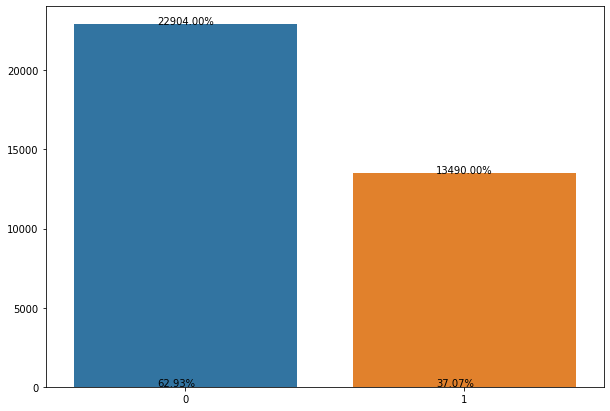

In [14]:
plot_feature_freq(dados_droped, 'trocou_aparelho')

In [15]:
# dados_droped = dados_droped.tail(dados_droped.shape[0] -230000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_droped['idade'] = np.asarray(dados_droped['idade'], dtype = 'int16')
dados_droped['fl_3g'] = np.asarray(dados_droped['fl_3g'], dtype = 'int8')
dados_droped['fl_4g'] = np.asarray(dados_droped['fl_4g'], dtype = 'int8')
dados_droped['fl_5g'] = np.asarray(dados_droped['fl_5g'], dtype = 'int8')
# dados_droped2 = dados_droped[dados_droped['trocou_aparelho'] == 1].reset_index()
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
2384,5599999514051,724119896599686,35179339,2021-08-30,NaN,13,1,0,APPLE,IPHONE 12 (A2172),...,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0,0,1,2018,60,13.0,5.67
36043,5599999041625,724119813970292,35468011,2020-10-30,2022-02-19,15,1,1,Samsung Korea,GALAXY S20,...,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0,1,0,2020,46,0.0,15.00
12040,5599996471818,724119896006113,35299510,2021-07-20,NaN,15,1,0,SAMSUNG,"GALAXY J6 (SM-J600GT,DS)",...,MARANHAO,VIVO CONTROLE 9GB I,60.74,0,1,0,2020,46,0.0,0.00
24078,5599992301834,724119892795038,35571411,2020-09-19,2022-02-17,16,1,1,Samsung Korea,GALAXY J2 CORE,...,MARANHAO,VIVO CONTROLE-9GB ILIM_,66.99,0,1,0,2020,76,16.0,16.00
26523,5599992274142,724119109936296,86890904,2021-04-22,2022-04-25,12,1,1,XIAOMI,REDMI NOTE 8 PRO (M1906G7G),...,MARANHAO,VIVO CTRL DIGITAL-14GB ILIM_,86.99,0,1,0,2018,44,12.0,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25629,5511910021165,724102901916694,35183711,2020-10-15,2022-03-17,17,1,1,Samsung Korea,GALAXY A10S,...,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0,1,0,2020,39,0.0,14.00
16331,5511910017834,724101106626336,35547360,2021-08-15,NaN,14,1,0,Samsung Korea,GALAXY A02S,...,SAO PAULO,VIVO CONTROLE 5GB II,42.19,0,1,0,2020,38,0.0,0.00
31225,5511910012510,724102111092552,86987605,2020-12-24,2022-03-05,14,1,1,XIAOMI,REDMI 9 (M2004J19G),...,SAO PAULO,Linha Adicional Vivo Pós Família 300GB,69.99,0,1,0,2016,44,4.0,13.00
10724,5511910010690,724102091025544,35179738,2021-05-14,NaN,17,1,0,SAMSUNG,GALAXY A01 (SM-A015M),...,SAO PAULO,VIVO CONTROLE 4GB I PLN,26.99,0,1,0,2016,38,0.0,0.00


In [16]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36394 entries, 2384 to 2914
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   msisdn                   36394 non-null  int64  
 1   imsi                     36394 non-null  object 
 2   tac                      36394 non-null  int64  
 3   dt_inicio                36394 non-null  object 
 4   dt_fim                   12653 non-null  object 
 5   aging_aparelho           36394 non-null  int64  
 6   cat_aparelho             36394 non-null  int64  
 7   trocou_aparelho          36394 non-null  int64  
 8   fabricante               36394 non-null  object 
 9   modelo                   36394 non-null  object 
 10  imei                     36394 non-null  object 
 11  ranking                  36394 non-null  int64  
 12  cpfidentifier            36394 non-null  int64  
 13  subscriberkey            36394 non-null  int64  
 14  customerkey         

***
## Mostrando a correlação entre os dados numéricos

In [17]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking', 'aging_aparelho',
                                     'offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade', 'trocou_aparelho']]

<AxesSubplot:>

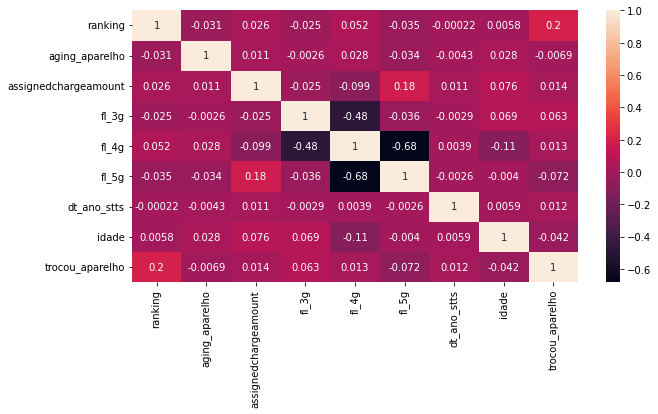

In [18]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

#### Correlação entre Meses do ano com Troca de Aparelho

In [19]:
dados_droped['mes_jan'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-01') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-01')

dados_droped['mes_fev'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-02') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-02')

dados_droped['mes_mar'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-03') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-03')

dados_droped['mes_abr'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-04') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-04')

dados_droped['mes_mai'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-05') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-05')

dados_droped['mes_jun'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-06') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-06')

dados_droped['mes_jul'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-07') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-07')  
                                                
dados_droped['mes_ago'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-08') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-08')

dados_droped['mes_set'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-09') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-09')

dados_droped['mes_out'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-10') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-10')

dados_droped['mes_nov'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-11') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-11')

dados_droped['mes_dez'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-12') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-12')

In [20]:
corr_meses_troca = dados_droped[['mes_jan', 'mes_fev', 'mes_mar', 'mes_abr', 
                                 'mes_mai', 'mes_jun', 'mes_jul', 'mes_ago', 
                                 'mes_set', 'mes_out', 'mes_nov', 'mes_dez', 'trocou_aparelho']]

<AxesSubplot:>

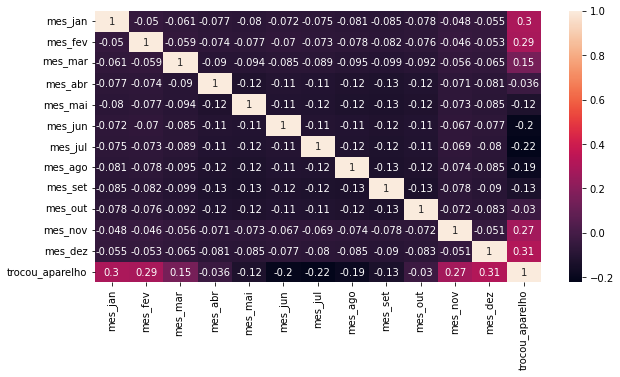

In [21]:
corr_Test = corr_meses_troca.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_Test, xticklabels = corr_Test.columns, yticklabels = corr_Test.columns, annot = True)

***
## Exploração dos dados

### seleção de features

In [22]:
# define features
X_ta = dados_droped[['fabricante', 'modelo', 'ranking', 'aging_aparelho', 
                     'offertechnology', 
                     'statedesc', 'subscribermainofferdesc', 'assignedchargeamount', 
                     'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf']]
X_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
2384,APPLE,IPHONE 12 (A2172),1,13,PostPaid,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0,0,1,2018,60,13.0,5.67
36043,Samsung Korea,GALAXY S20,1,15,PostPaid,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0,1,0,2020,46,0.0,15.00
12040,SAMSUNG,"GALAXY J6 (SM-J600GT,DS)",1,15,Controle,MARANHAO,VIVO CONTROLE 9GB I,60.74,0,1,0,2020,46,0.0,0.00
24078,Samsung Korea,GALAXY J2 CORE,1,16,Controle,MARANHAO,VIVO CONTROLE-9GB ILIM_,66.99,0,1,0,2020,76,16.0,16.00
26523,XIAOMI,REDMI NOTE 8 PRO (M1906G7G),1,12,Controle,MARANHAO,VIVO CTRL DIGITAL-14GB ILIM_,86.99,0,1,0,2018,44,12.0,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25629,Samsung Korea,GALAXY A10S,1,17,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0,1,0,2020,39,0.0,14.00
16331,Samsung Korea,GALAXY A02S,1,14,Controle,SAO PAULO,VIVO CONTROLE 5GB II,42.19,0,1,0,2020,38,0.0,0.00
31225,XIAOMI,REDMI 9 (M2004J19G),1,14,PostPaid,SAO PAULO,Linha Adicional Vivo Pós Família 300GB,69.99,0,1,0,2016,44,4.0,13.00
10724,SAMSUNG,GALAXY A01 (SM-A015M),1,17,Controle,SAO PAULO,VIVO CONTROLE 4GB I PLN,26.99,0,1,0,2016,38,0.0,0.00


In [23]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36394 entries, 2384 to 2914
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fabricante               36394 non-null  object 
 1   modelo                   36394 non-null  object 
 2   ranking                  36394 non-null  int64  
 3   aging_aparelho           36394 non-null  int64  
 4   offertechnology          36394 non-null  object 
 5   statedesc                36394 non-null  object 
 6   subscribermainofferdesc  36394 non-null  object 
 7   assignedchargeamount     36394 non-null  float64
 8   fl_3g                    36394 non-null  int8   
 9   fl_4g                    36394 non-null  int8   
 10  fl_5g                    36394 non-null  int8   
 11  dt_ano_stts              36394 non-null  int64  
 12  idade                    36394 non-null  int16  
 13  avg_msisdn               36394 non-null  float64
 14  avg_cpf             

#### Variaveis Categoricas

In [24]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [25]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  6
['ranking', 'aging_aparelho', 'assignedchargeamount', 'dt_ano_stts', 'avg_msisdn', 'avg_cpf']


***
## Mostrando a correlação entre os dados numéricos

In [26]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking','offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf', 'aging_aparelho', 'trocou_aparelho']]

<AxesSubplot:>

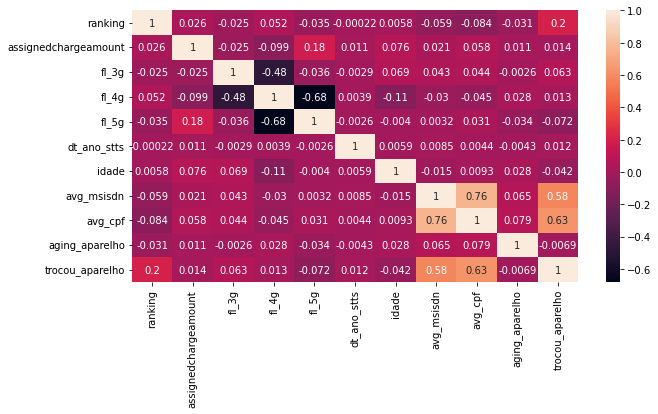

In [27]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

***
***
***
## Definição do Target trocou_aparelho

In [28]:
def plot_feature_freq(df, feature, qt_cat):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    order = np.argsort(counts)[::-1]
    labels, counts = labels[order], counts[order]

    g = sns.barplot(labels[:qt_cat], counts[:qt_cat])
    g.set_xticklabels(labels[:qt_cat], rotation=90)
    
    return g

In [29]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 22904, 1: 13490})

<AxesSubplot:>

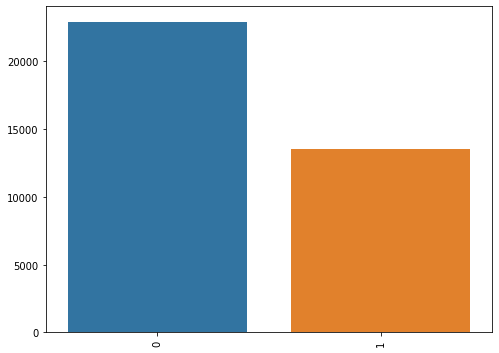

In [30]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho', len(dados_droped['trocou_aparelho'].unique()))

***
## Modelagem trocou_aparelho

In [31]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_ta[numerical_cols_ta] = scaler.fit_transform(X_ta[numerical_cols_ta])

In [32]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

In [33]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train_ta = X_train_ta.copy()
label_X_valid_ta = X_val_ta.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder_ta = OrdinalEncoder()
label_X_train_ta[object_cols_ta] = ordinal_encoder_ta.fit_transform(label_X_train_ta[object_cols_ta])
label_X_valid_ta[object_cols_ta] = ordinal_encoder_ta.fit_transform(label_X_valid_ta[object_cols_ta])

In [34]:
model_ta = GradientBoostingClassifier(random_state=2048)
model_ta.fit(label_X_train_ta, y_train_ta)
preds_ta = model_ta.predict(label_X_valid_ta)

***
### Feature Importance

In [35]:
import eli5
from eli5.sklearn import PermutationImportance

perm_ta = PermutationImportance(model_ta, n_iter=100).fit(label_X_valid_ta, y_val_ta)
eli5.show_weights(perm_ta, feature_names = label_X_valid_ta.columns.tolist())

Weight,Feature
0.3467 ± 0.0067,avg_cpf
0.0327 ± 0.0012,ranking
0.0205 ± 0.0020,avg_msisdn
0.0031 ± 0.0016,fabricante
0.0010 ± 0.0009,subscribermainofferdesc
0.0009 ± 0.0007,fl_5g
0.0007 ± 0.0008,aging_aparelho
0.0003 ± 0.0005,idade
0.0001 ± 0.0002,fl_3g
0.0000 ± 0.0001,dt_ano_stts


Permutation explainer: 18198it [25:01, 12.07it/s]                           


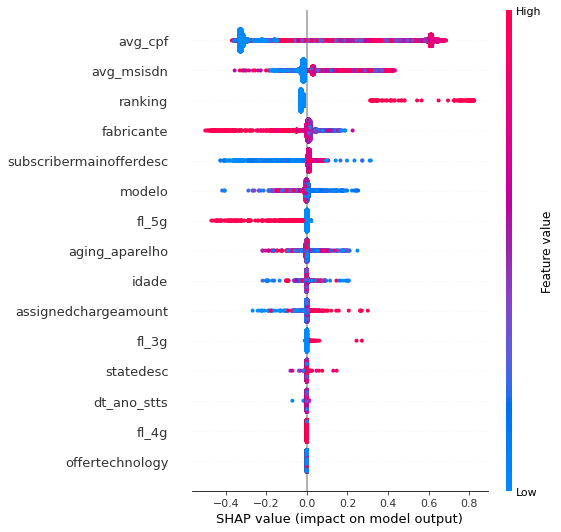

In [36]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer_ta = shap.Explainer(model_ta.predict, label_X_valid_ta)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values_ta = explainer_ta(label_X_valid_ta)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values_ta, label_X_valid_ta)

  0%|          | 0/1819 [00:00<?, ?it/s]

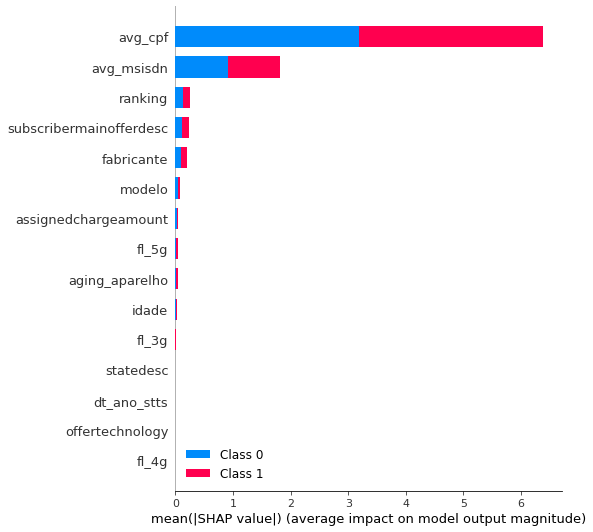

In [37]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample_ta = label_X_train_ta.sample(n=min(10, len(label_X_train_ta.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example_ta = label_X_valid_ta.sample(n=int((label_X_valid_ta.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict_ta = lambda x: model_ta.predict_proba(pd.DataFrame(x, columns=label_X_train_ta.columns))
explainer_ta2 = KernelExplainer(predict_ta, train_sample_ta, link="logit")
shap_values_ta2 = explainer_ta2.shap_values(example_ta, l1_reg=False)
summary_plot(shap_values_ta2, example_ta)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

***
## Métricas

In [38]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     11419
           1       0.90      0.95      0.92      6778

    accuracy                           0.94     18197
   macro avg       0.93      0.94      0.94     18197
weighted avg       0.94      0.94      0.94     18197



In [39]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,10670,749
1,344,6434


Confusion matrix, without normalization
[[10670   749]
 [  344  6434]]
Normalized confusion matrix
[[0.93440757 0.06559243]
 [0.05075243 0.94924757]]


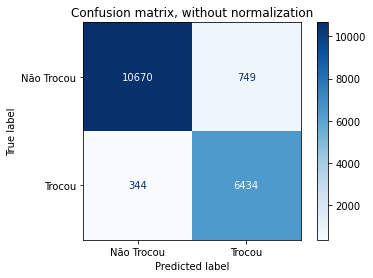

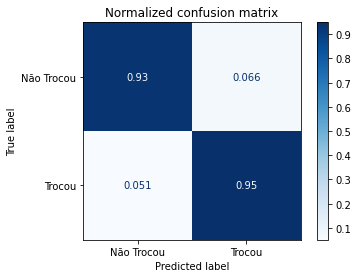

<Figure size 1296x1296 with 0 Axes>

In [40]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_ta,
        label_X_valid_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

In [41]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<AxesSubplot:>

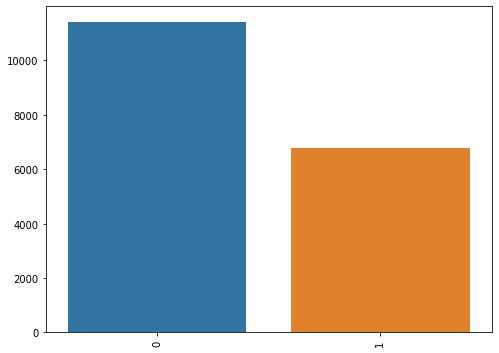

In [42]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho', len(X_val_ta['trocou_aparelho'].unique()))

In [43]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<AxesSubplot:>

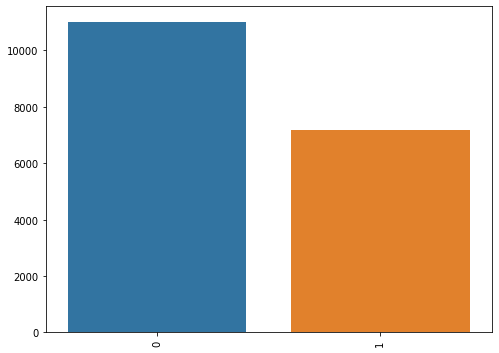

In [44]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto', len(X_val_ta['trocou_aparelho_previsto'].unique()))

In [45]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [46]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [47]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
# X_val_ta

In [48]:
X_val_ta['aging_aparelho_ori'] = dados_droped['aging_aparelho']
X_val_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,...,dt_ano_stts,idade,avg_msisdn,avg_cpf,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,aging_aparelho_ori
3655,"Motorola Mobility LLC, a Lenovo Company",CAPRIPLUS21,-0.155478,-0.384015,PostPaid,PERNAMBUCO,TITULAR VIVO PÓS MIG_20GB,0.670116,0,1,...,-0.514005,38,-0.604499,-0.748818,0,0,731231376,2021-07-26,NaN,14
31442,NOKIA,C2-01.5,-0.155478,1.630012,Controle,MINAS GERAIS,VIVO CONTROLE 6GB III,-0.190078,1,0,...,0.077044,47,1.651400,1.422840,1,1,2978775696,2020-11-26,2022-06-20,18
2014,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,-0.155478,-1.391028,Controle,SAO PAULO,VIVOCONTROLEDIGITAL-9GB ILIM_,0.466002,0,1,...,0.668093,58,-0.604499,-0.748818,0,0,7793097823,2021-09-28,NaN,12
23167,SAMSUNG,GALAXY A01 (SM-A015M),-0.155478,0.622999,Controle,SAO PAULO,VIVO CONTROLE 8GB II PLN,-0.186870,0,1,...,0.668093,35,-0.604499,1.181545,1,1,34995214828,2020-11-01,2022-03-29,16
12337,SAMSUNG,"GALAXY A30S (SM-A307GT,DS)",-0.155478,-0.384015,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.459800,0,1,...,0.668093,23,-0.604499,1.543488,0,1,50912660899,2021-08-09,NaN,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517,SAMSUNG,GALAXY J1 DUOS (SM-J120H DS),-0.155478,-1.391028,Controle,GOIAS,VIVO CONTROLE 5GB II,-0.335873,1,0,...,-1.696103,76,-0.604499,-0.748818,0,0,59146354700,2021-10-16,NaN,12
21874,APPLE,IPHONE 11 (A2221),-0.155478,0.622999,PostPaid,RIO DE JANEIRO,Titular Vivo Pós Família 180GB,1.530310,0,1,...,0.668093,50,-0.604499,-0.748818,0,0,2400942714,2021-06-18,NaN,16
35149,"Motorola Mobility LLC, a Lenovo Company","BL12494645, MOTO G (6TH GEN)",-0.155478,1.126505,Controle,MINAS GERAIS,VIVO CONTROLE 7GB_,-0.170833,0,1,...,-0.514005,39,-0.604499,1.302192,1,1,1505171652,2020-12-20,2022-05-31,17
16055,"Motorola Mobility LLC, a Lenovo Company",CAPRIPLUS21,-0.155478,0.119492,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 5GB II,-0.323772,0,1,...,-1.105054,41,-0.604499,-0.748818,0,0,880202076,2021-06-28,NaN,15


***
***
***
## Separando as bases para outro modelo

In [49]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,...,dt_ano_stts,idade,avg_msisdn,avg_cpf,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,aging_aparelho_ori
0,NOKIA,C2-01.5,-0.155478,1.630012,Controle,MINAS GERAIS,VIVO CONTROLE 6GB III,-0.190078,1,0,...,0.077044,47,1.651400,1.422840,1,1,2978775696,2020-11-26,2022-06-20,18
1,SAMSUNG,GALAXY A01 (SM-A015M),-0.155478,0.622999,Controle,SAO PAULO,VIVO CONTROLE 8GB II PLN,-0.186870,0,1,...,0.668093,35,-0.604499,1.181545,1,1,34995214828,2020-11-01,2022-03-29,16
2,SAMSUNG,"GALAXY A30S (SM-A307GT,DS)",-0.155478,-0.384015,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.459800,0,1,...,0.668093,23,-0.604499,1.543488,0,1,50912660899,2021-08-09,NaN,14
3,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,-0.155478,1.126505,Controle,RIO DE JANEIRO,VIVO CONTROLE 7GB - MENSAL,-0.102601,0,1,...,0.077044,58,-0.604499,1.000573,0,1,92009360753,2021-04-22,NaN,17
4,"SHANDONG KAER ELECTRIC CO.,LTD",KT1000,-0.155478,-1.391028,Controle,RIO DE JANEIRO,VIVO CONTROLE 11GB - ANUAL_,0.020014,0,0,...,0.668093,64,0.147467,0.135529,1,1,57192260797,2021-05-05,2022-06-04,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7178,MOTOROLA,MOTO E (4TH GEN),-0.155478,1.630012,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 5GB II PLN,-0.467090,0,1,...,0.077044,38,1.651400,1.422840,1,1,1380129036,2020-09-23,2022-03-25,18
7179,Positivo Tecnologia S.A.,P26,-0.155478,-0.887522,Controle,SERGIPE,VIVO CONTROLE 9GB I PLN,-0.236732,0,0,...,-1.696103,73,0.210131,0.035392,1,1,35132124704,2021-02-10,2022-03-22,13
7180,"Motorola Mobility LLC, a Lenovo Company",CAPRIPLUS21,-0.155478,0.119492,PostPaid,RIO GRANDE DO SUL,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,0.816058,0,1,...,0.668093,32,0.648778,0.759278,0,1,959209000,2021-07-09,NaN,15
7181,XIAOMI,REDMI NOTE 8 (M1908C3JG),-0.155478,-1.391028,Controle,BAHIA,VIVO CONTROLE 4GB,-0.350453,0,1,...,-1.105054,31,0.899434,0.698954,1,1,85839864528,2021-02-03,2022-02-25,12


***
***
***
## Definição do Target aging_aparelho

In [50]:
# define target
y = base_to_pred_month['aging_aparelho_ori']

In [51]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({18: 814, 16: 935, 14: 1077, 17: 955, 12: 1288, 13: 1143, 15: 971})

<AxesSubplot:>

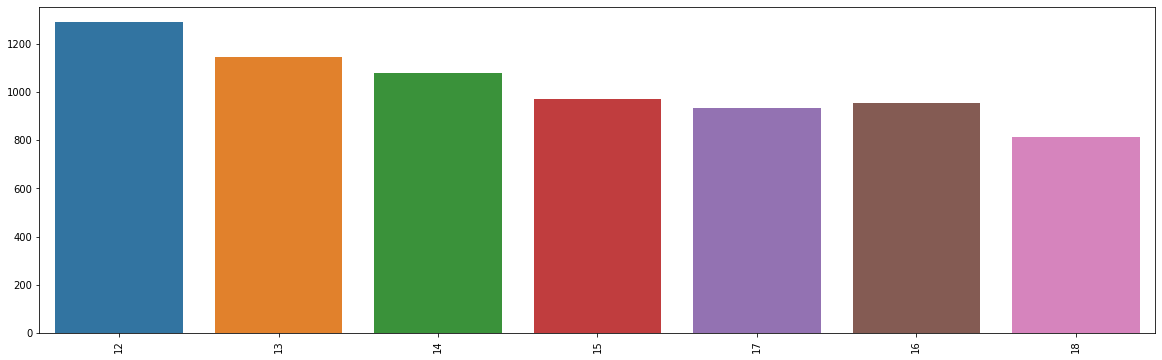

In [52]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho_ori', len(base_to_pred_month['aging_aparelho_ori'].unique()))

### Definicão das features

In [53]:
# define features
X = base_to_pred_month[['fabricante', 'modelo',
                        'ranking',
                        'offertechnology', 
                        'statedesc', 'subscribermainofferdesc',
                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                        'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf']]
X

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,NOKIA,C2-01.5,-0.155478,Controle,MINAS GERAIS,VIVO CONTROLE 6GB III,-0.190078,1,0,0,0.077044,47,1.651400,1.422840
1,SAMSUNG,GALAXY A01 (SM-A015M),-0.155478,Controle,SAO PAULO,VIVO CONTROLE 8GB II PLN,-0.186870,0,1,0,0.668093,35,-0.604499,1.181545
2,SAMSUNG,"GALAXY A30S (SM-A307GT,DS)",-0.155478,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.459800,0,1,0,0.668093,23,-0.604499,1.543488
3,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,-0.155478,Controle,RIO DE JANEIRO,VIVO CONTROLE 7GB - MENSAL,-0.102601,0,1,0,0.077044,58,-0.604499,1.000573
4,"SHANDONG KAER ELECTRIC CO.,LTD",KT1000,-0.155478,Controle,RIO DE JANEIRO,VIVO CONTROLE 11GB - ANUAL_,0.020014,0,0,0,0.668093,64,0.147467,0.135529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7178,MOTOROLA,MOTO E (4TH GEN),-0.155478,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 5GB II PLN,-0.467090,0,1,0,0.077044,38,1.651400,1.422840
7179,Positivo Tecnologia S.A.,P26,-0.155478,Controle,SERGIPE,VIVO CONTROLE 9GB I PLN,-0.236732,0,0,0,-1.696103,73,0.210131,0.035392
7180,"Motorola Mobility LLC, a Lenovo Company",CAPRIPLUS21,-0.155478,PostPaid,RIO GRANDE DO SUL,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,0.816058,0,1,0,0.668093,32,0.648778,0.759278
7181,XIAOMI,REDMI NOTE 8 (M1908C3JG),-0.155478,Controle,BAHIA,VIVO CONTROLE 4GB,-0.350453,0,1,0,-1.105054,31,0.899434,0.698954


#### Variaveis Categoricas

In [54]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [55]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  5
['ranking', 'assignedchargeamount', 'dt_ano_stts', 'avg_msisdn', 'avg_cpf']


***
## Mostrando a correlação entre os dados numéricos

In [56]:
corr_mes_previsao = base_to_pred_month[['fabricante', 'modelo',
                                        'ranking',
                                        'offertechnology', 
                                        'statedesc', 'subscribermainofferdesc',
                                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                        'dt_ano_stts', 'idade', 'aging_aparelho_ori', 'avg_msisdn', 'avg_cpf']]

<AxesSubplot:>

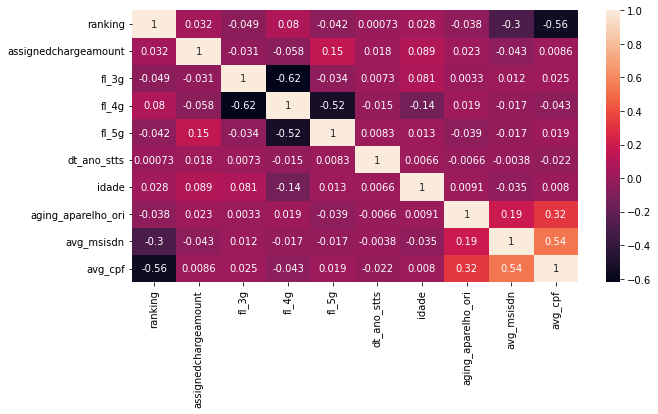

In [57]:
corr2 = corr_mes_previsao.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr2, xticklabels = corr2.columns, yticklabels = corr2.columns, annot = True)

***
## Modelagem

In [58]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [59]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

In [60]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_val.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.fit_transform(label_X_valid[object_cols])

model = GradientBoostingClassifier(random_state=2048)
model.fit(label_X_train, y_train)
preds = model.predict(label_X_valid)

***
### Feature Importance

In [61]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, n_iter=100).fit(label_X_valid, y_val)
eli5.show_weights(perm, feature_names = label_X_valid.columns.tolist())


Weight,Feature
0.3316 ± 0.0134,avg_msisdn
0.1903 ± 0.0102,avg_cpf
0.0067 ± 0.0017,ranking
0.0047 ± 0.0039,modelo
0.0040 ± 0.0035,subscribermainofferdesc
0.0034 ± 0.0035,idade
0.0034 ± 0.0042,fabricante
0.0023 ± 0.0037,assignedchargeamount
0.0009 ± 0.0022,dt_ano_stts
0.0005 ± 0.0011,fl_5g


Permutation explainer: 3593it [18:53,  3.14it/s]                          


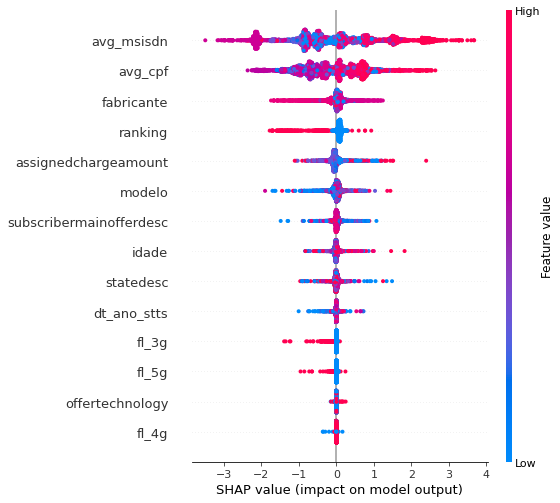

In [62]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.Explainer(model.predict, label_X_valid)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer(label_X_valid)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, label_X_valid)

  0%|          | 0/359 [00:00<?, ?it/s]

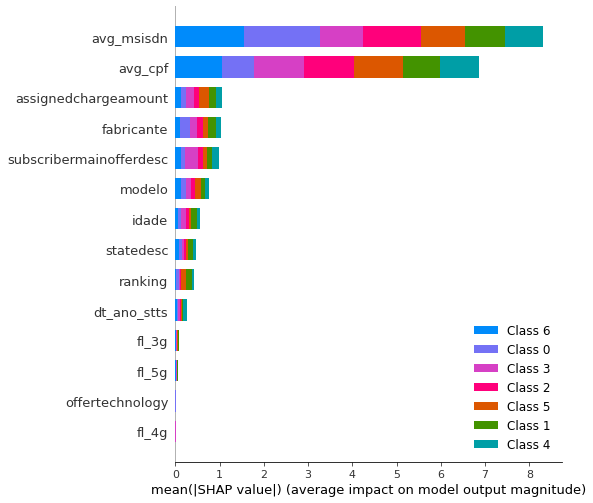

In [63]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = label_X_train.sample(n=min(10, len(label_X_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = label_X_valid.sample(n=int((label_X_valid.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=label_X_train.columns))
explainer2 = KernelExplainer(predict, train_sample, link="logit")
shap_values2 = explainer2.shap_values(example, l1_reg=False)
summary_plot(shap_values2, example)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

***
## Métricas

In [64]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          12       0.62      0.83      0.71       658
          13       0.80      0.69      0.74       556
          14       0.80      0.73      0.76       546
          15       0.81      0.72      0.77       497
          16       0.77      0.69      0.73       447
          17       0.66      0.74      0.70       459
          18       0.82      0.70      0.75       429

    accuracy                           0.73      3592
   macro avg       0.75      0.73      0.74      3592
weighted avg       0.75      0.73      0.74      3592



In [65]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

,12,13,14,15,16,17,18
12,548,25,20,15,8,26,16
13,79,384,20,23,21,22,7
14,58,16,399,16,17,28,12
15,43,18,21,360,19,26,10
16,54,18,12,14,309,33,7
17,61,11,13,8,11,340,15
18,47,10,14,7,15,37,299


## Plot non-normalized confusion matrix

Confusion matrix, without normalization
[[548  25  20  15   8  26  16]
 [ 79 384  20  23  21  22   7]
 [ 58  16 399  16  17  28  12]
 [ 43  18  21 360  19  26  10]
 [ 54  18  12  14 309  33   7]
 [ 61  11  13   8  11 340  15]
 [ 47  10  14   7  15  37 299]]
Normalized confusion matrix
[[0.83282675 0.03799392 0.03039514 0.02279635 0.01215805 0.03951368
  0.02431611]
 [0.14208633 0.69064748 0.03597122 0.04136691 0.03776978 0.03956835
  0.01258993]
 [0.10622711 0.02930403 0.73076923 0.02930403 0.03113553 0.05128205
  0.02197802]
 [0.08651911 0.0362173  0.04225352 0.72434608 0.03822938 0.05231388
  0.02012072]
 [0.12080537 0.04026846 0.02684564 0.03131991 0.69127517 0.0738255
  0.01565996]
 [0.1328976  0.02396514 0.02832244 0.01742919 0.02396514 0.74074074
  0.03267974]
 [0.10955711 0.02331002 0.03263403 0.01631702 0.03496503 0.08624709
  0.6969697 ]]


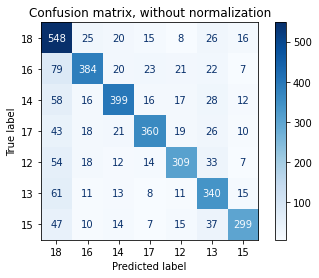

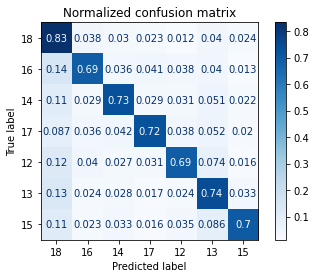

<Figure size 1296x1296 with 0 Axes>

In [66]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        label_X_valid,
        y_val,
        display_labels=y.unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [67]:
X_val['aging_aparelho'] = y_val
# X_val

In [68]:
X_val['previsto'] = preds
# X_val

In [69]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [70]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [71]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [72]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,aging_aparelho,previsto,cpfidentifier,dt_inicio,dt_fim,dt_fim_previsto
679,Samsung Korea,GALAXY A31,-0.246356,Controle,SAO PAULO,VIVO CONTROLE 6GB III,-0.248980,0,1,0,0.073518,27,-1.469805,0.851055,17,17,8626124465,2020-11-29,2022-05-27,2022-04
2770,SAMSUNG,GALAXY J6 (SM-J600GT DS),-0.246356,Controle,PARA,VIVO CTRL DIGITAL_11GB ILIM_,-0.017678,0,1,0,1.281939,45,-0.108548,-0.592651,18,18,51954125291,2020-07-28,2022-02-26,2022-01
5526,APPLE,IPHONE 11 (A2221),-0.246356,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 60GB PLN,-0.584200,0,1,0,-0.530693,58,1.797211,0.919116,18,17,6667385806,2020-12-02,2022-06-19,2022-05
4028,LG Electronics Inc.,LM-X210BMW,-0.246356,Controle,SAO PAULO,VIVO CONTROLE 7GB_,-0.154087,0,1,0,0.073518,62,-1.061428,-0.695773,16,12,1181622840,2020-09-29,2022-02-23,2021-09
4890,SAMSUNG,"GALAXY A01 (SM-A015M,DS)",-0.246356,Controle,MINAS GERAIS,VIVO CONTROLE 5GB IV,-0.365017,0,1,0,0.073518,39,-1.469805,1.057299,18,18,5523053678,2020-09-19,2022-03-22,2022-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,APPLE,IPHONE 11 (A2221),-0.246356,PostPaid,DISTRITO FEDERAL,Titular Vivo Pós Família 180GB,1.336869,0,1,0,0.677729,57,0.299829,0.026080,13,13,26736004187,2021-04-14,2022-06-11,2022-05
3009,LG,LM-K525BMW,-0.246356,Controle,PARA,VIVO CTRL DIGITAL_5GB_,-0.280181,0,1,0,0.677729,41,-0.312737,-0.902016,17,17,72998784291,2021-05-02,NaN,2022-10
1381,Samsung Korea,GALAXY A20,-0.246356,Controle,MARANHAO,VIVO CONTROLE 4GB IV,-0.358571,0,1,0,0.677729,26,0.844332,0.851055,17,17,61207589330,2020-11-12,2022-05-08,2022-04
4696,SAMSUNG,GALAXY J5 2017 (SM-J530G DS),-0.246356,Controle,RIO DE JANEIRO,VIVO CONTROLE 4GB,-0.372366,0,1,0,0.677729,40,-0.653051,-1.417625,12,12,9601203788,2021-04-29,2022-05-15,2022-04


<AxesSubplot:>

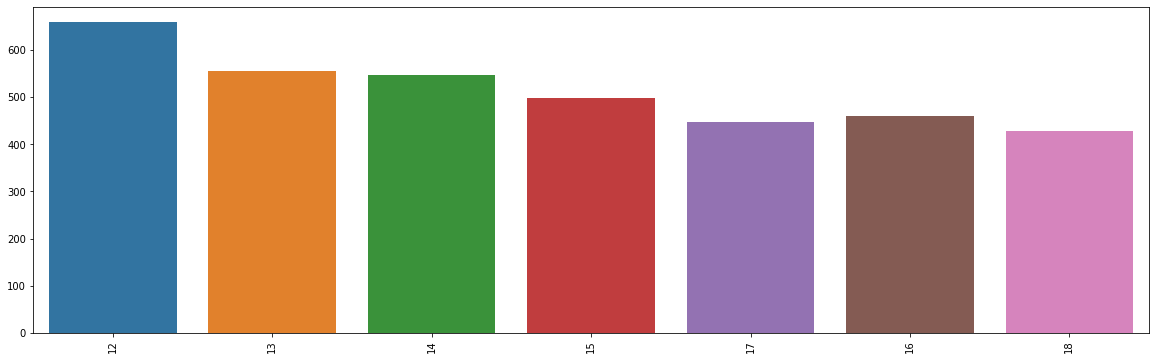

In [73]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'aging_aparelho', len(X_val['aging_aparelho'].unique()))

<AxesSubplot:>

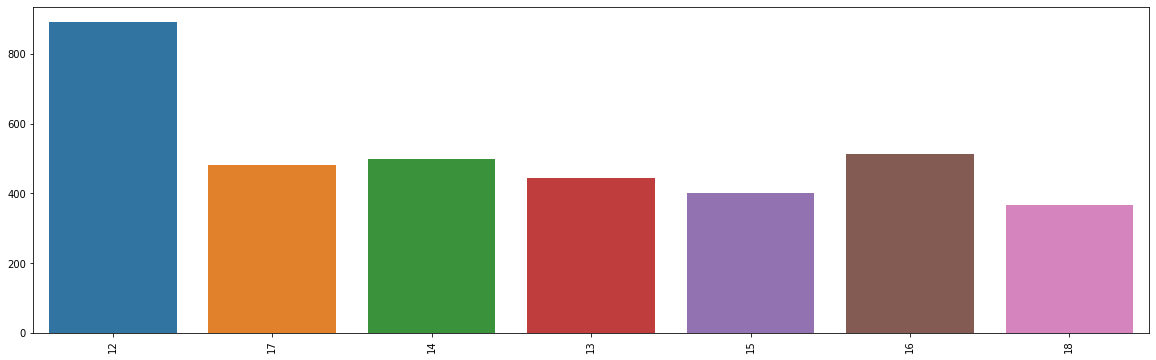

In [75]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'previsto', len(X_val['previsto'].unique()))